In [546]:
import numpy as np
import pandas as pd
import torch
from permetrics import RegressionMetric

from experiment_runner import (
    ControlGDConfig,
    ControlEMVPConfig,
    ProposedMethodConfig,
    run_comparison_experiments,
)
from svd_based_optimizer import SvdOptimizer
from ols_optimizer import OlsOptimizer
import matplotlib.pyplot as plt
from dimension_estimation import estimate_dimension, OptimalDimensionSelectionMethod, CaoEstimator
from lag_estimation import estimate_tau, OptimalLagSelectionMethod, AmiEstimator
from cv_embedding_estimation import CrossValidationEmbeddingEstimator, estimate_embedding_cv
from itertools import product
import seaborn as sns
from matplotlib.colors import LogNorm


## Loading the dataset

In [2]:
# dataset = pd.read_csv(r".\data\SeriesReport-Seasonally Adjusted Sales - Monthly (Millions of Dollars).csv")
dataset = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/datasets/lynx.csv',
                   index_col=0)
dataset.set_index('time', inplace=True)
dataset.head()

,value
time,
1821,269
1822,321
1823,585
1824,871
1825,1475


In [3]:
dataset.describe()

,value
count,114.000000
mean,1538.017544
std,1585.843914
min,39.000000
25%,348.250000
50%,771.000000
75%,2566.750000
max,6991.000000


In [4]:
# time_series = dataset['Value'].values
time_series = dataset['value'].values
time_series = time_series[np.nonzero(~np.isnan(time_series))]

In [5]:
# time_series_mu = np.mean(time_series)
# time_series_std = np.std(time_series)

# time_series = np.diff(time_series, prepend=time_series[0])
# time_series = (time_series - time_series_mu) / time_series_std
time_series = np.log10(time_series)

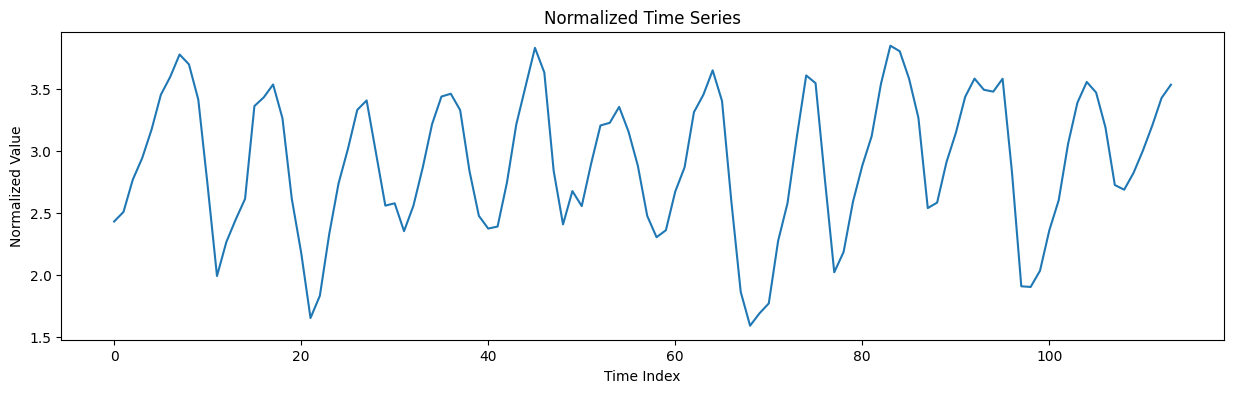

In [6]:
plt.figure(figsize=(15, 4))
plt.plot(time_series)
plt.title('Normalized Time Series')
plt.xlabel('Time Index')
plt.ylabel('Normalized Value')
plt.show()

## Estimating the embedding parameters

In [7]:
ami_tau = estimate_tau(
    time_series,
    estimator=AmiEstimator(
        max_lag=20, optimum_selection_method=OptimalLagSelectionMethod.FIRST_LOC_MIN
    ),
)
print(f"Estimated tau: {ami_tau}")

Estimated tau: 2


In [8]:
cao_dim = estimate_dimension(
    time_series,
    estimator=CaoEstimator(
        delay=ami_tau,
        max_dim=10,
        optimum_selection_method=OptimalDimensionSelectionMethod.E1_E2_COMBINED,
        plot=False,
    ),
)
print(f"Estimated dimension: {cao_dim}")

Estimated dimension: 7


## Testing Cross-Validation Embedding Estimation

Let's compare the traditional AMI + Cao's method with the new modified multifold cross-validation criterion for embedding parameter estimation.

In [9]:
# Compare traditional AMI + Cao estimation with CV-based estimation
print("=== Traditional Methods (AMI + Cao) ===")
print(f"AMI estimated tau: {ami_tau}")
print(f"Cao estimated dimension: {cao_dim}")

# Use CV-based estimation with a smaller parameter space for faster computation
print("\n=== Cross-Validation Based Estimation ===")
cv_estimator = CrossValidationEmbeddingEstimator(
    tau_range=(1, 5),      # Smaller range for demonstration
    dim_range=(2, 6),      # Smaller range for demonstration  
    n_splits=3,            # Fewer splits for faster computation
    scoring_metric="mse",  # Mean squared error
    verbose=False
)

tau_cv, dim_cv = cv_estimator.estimate(time_series)
print(f"CV estimated tau: {tau_cv}")
print(f"CV estimated dimension: {dim_cv}")

=== Traditional Methods (AMI + Cao) ===
AMI estimated tau: 2
Cao estimated dimension: 7

=== Cross-Validation Based Estimation ===
CV estimated tau: 1
CV estimated dimension: 2


In [10]:
# You can also try different scoring metrics
print("\n=== CV with different scoring metrics ===")

metrics = ["mse", "mae", "r2"]
cv_results = {}

for metric in metrics:
    estimator = CrossValidationEmbeddingEstimator(
        tau_range=(1, 4),
        dim_range=(2, 5),
        n_splits=3,
        scoring_metric=metric,
        verbose=False  # Set to True to see progress
    )
    tau_est, dim_est = estimator.estimate(time_series)
    cv_results[metric] = (tau_est, dim_est)
    print(f"{metric.upper()} metric: tau={tau_est}, dim={dim_est}")

print(f"\nComparison:")
print(f"Traditional (AMI+Cao): tau={ami_tau}, dim={cao_dim}")
for metric, (tau_est, dim_est) in cv_results.items():
    print(f"CV ({metric}): tau={tau_est}, dim={dim_est}")


=== CV with different scoring metrics ===
MSE metric: tau=1, dim=2
MAE metric: tau=1, dim=2
R2 metric: tau=1, dim=2

Comparison:
Traditional (AMI+Cao): tau=2, dim=7
CV (mse): tau=1, dim=2
CV (mae): tau=1, dim=2
CV (r2): tau=1, dim=2


## Configuring the models

In [11]:
tau, dim = tau_cv, dim_cv

In [100]:
proposed_configs = [
    *[
        ProposedMethodConfig(
            approach=approach,
            optimizer=SvdOptimizer(epsilon=eps, alpha=alpha),
            # m=m,
            post_tune=post_tune,
            n=dim,
            embedding_tau=tau,
            tuning_val_split=0.3,
            ridge=ridge # for pre-training
        )
        # for m in [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50]
        for alpha in [0, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1, 5e-1, 1]
        for post_tune in [True, False]
        for eps in [0, 0.0001, 0.001, 0.01, 0.025, 0.05, 0.1, 0.5]
        # for ridge in [0.0, 1e-4, 1e-3, 1e-2]
        # for approach in ["pretraining", "no-pretraining"]
        for ridge, approach in filter(
            lambda ra: not (ra[0] > 0 and ra[1] == "no-pretraining"), 
            product(
                [0.0, 1e-4, 1e-3, 1e-2], 
                ["pretraining", "no-pretraining"]
            )
        )
    ],
    # *[
    #     ProposedMethodConfig(
    #         approach=approach,
    #         optimizer=OlsOptimizer(rho=rho),
    #         m=max_m,
    #         n=dim,
    #         embedding_tau=tau,
    #         post_tune=post_tune,
    #     )
    #     for max_m in [50, 80]
    #     for rho in [0.01, 0.05, 0.1, 0.3, 0.6]
    #     for post_tune in [True, False]
    #     for approach in ["pretraining", "no-pretraining"]
    # ],
]

control_configs = [
    # *[
    #     ControlGDConfig(
    #         m=m,
    #         n=dim,
    #         embedding_tau=tau,
    #         lr=lr,
    #         sigma_global=sigma_global,
    #         ridge=ridge,
    #         val_split=0.2,
    #     )
    #     for m in [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
    #     for lr in [1e-3, 1e-2, 5e-2, 1e-1]
    #     for ridge in [0.0, 1e-4, 1e-3, 1e-2]
    #     for sigma_global in [False, True]
    # ],
    *[
        ControlEMVPConfig(
            n=dim,
            embedding_tau=tau,
            num_components=m,
            ridge=ridge
        )
        for m in [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
        for ridge in [0.0, 1e-4, 1e-3, 1e-2]
    ]
]

In [411]:
TRAIN_RATIO = 0.7

In [412]:
proposed_results, control_results = run_comparison_experiments(
        time_series,
        proposed_configs,
        control_configs,
        train_ratio=TRAIN_RATIO, # 0.88 matches the article which introduces the EM-VP algorithm
        device="cuda" if torch.cuda.is_available() else "cpu",
        run_parallel=False,
        show_progress=True,
    )

if not isinstance(proposed_results, list):
    proposed_results = [proposed_results]
if not isinstance(control_results, list):
    control_results = [control_results]

Running Experiments: 100%|██████████| 764/764 [00:54<00:00, 14.08experiment/s]


## Evaluating the results

In [653]:
VALID_RATIO = 0.2

test_ratio = 1.0 - TRAIN_RATIO - VALID_RATIO
assert test_ratio > 0, "Test ratio must be positive."

In [654]:
results_df = pd.DataFrame(
    {
        "Type": [],
        "Name": [],
        "Test R": [],
        "Test R^2": [],
        "Test MSE": [],
        "Test RMSE": [],
        "Test NRMSE": [],
        "Test MAPE": [],
        "Test SMAPE": [],
        "Test MAAPE": [],
        "Valid R": [],
        "Valid R^2": [],
        "Valid MSE": [],
        "Valid RMSE": [],
        "Valid NRMSE": [],
        "Valid MAPE": [],
        "Valid SMAPE": [],
        "Valid MAAPE": [],
    }
)


use_validation_set = VALID_RATIO > 0

for i, res in enumerate(proposed_results):
    
    cfg = proposed_configs[i]
    
    validation_cutoff = int((len(res.test_targets) + len(res.train_targets)) * VALID_RATIO)
    
    test_metrics = RegressionMetric(
        y_pred=res.test_predictions[validation_cutoff:] if use_validation_set else res.test_predictions,
        y_true=res.test_targets[validation_cutoff:] if use_validation_set else res.test_targets,
    )
    
    if use_validation_set:
        valid_metrics = RegressionMetric(
            y_pred=res.test_predictions[:validation_cutoff],
            y_true=res.test_targets[:validation_cutoff],
        )

    new_row = pd.DataFrame(
        {
            "Type": ["Proposed"],
            "Name": [
                f"{res.metadata['optimizer_type']}-w.{cfg.approach}(m={res.metadata['total_centers']}, alpha={res.metadata['optimizer_params']['_alpha']}, eps={cfg.optimizer._epsilon} tuned={res.metadata['post_tuned']})" if res.metadata["optimizer_type"] == "SvdOptimizer" else
                f"{res.metadata['optimizer_type']}-w.{cfg.approach}(|C|={res.metadata['selected_centers']}, rho={res.metadata['optimizer_params']['_rho']} tuned={res.metadata['post_tuned']})"
            ],
            "Test R": [test_metrics.pearson_correlation_coefficient()],
            "Test R^2": [test_metrics.R2()],
            "Test RMSE": [test_metrics.root_mean_squared_error()],
            "Test NRMSE": [test_metrics.normalized_root_mean_square_error()],
            "Test MAPE": [test_metrics.mean_absolute_percentage_error()],
            "Test SMAPE": [test_metrics.symmetric_mean_absolute_percentage_error()],
            "Test MAAPE": [test_metrics.mean_arctangent_absolute_percentage_error()],
            "Test MSE": [test_metrics.mean_squared_error()],
            "Valid R": [valid_metrics.pearson_correlation_coefficient()] if use_validation_set else [np.nan],
            "Valid R^2": [valid_metrics.R2()] if use_validation_set else [np.nan],
            "Valid MSE": [valid_metrics.mean_squared_error()] if use_validation_set else [np.nan],
            "Valid RMSE": [valid_metrics.root_mean_squared_error()] if use_validation_set else [np.nan],
            "Valid NRMSE": [valid_metrics.normalized_root_mean_square_error()] if use_validation_set else [np.nan],
            "Valid MAPE": [valid_metrics.mean_absolute_percentage_error()] if use_validation_set else [np.nan],
            "Valid SMAPE": [valid_metrics.symmetric_mean_absolute_percentage_error()] if use_validation_set else [np.nan],
            "Valid MAAPE": [valid_metrics.mean_arctangent_absolute_percentage_error()] if use_validation_set else [np.nan],
        }
    )
    results_df = pd.concat([results_df, new_row], ignore_index=True)

for i, res in enumerate(control_results):
    
    cfg = control_configs[i]
    
    validation_cutoff = int((len(res.test_targets) + len(res.train_targets)) * VALID_RATIO)
    
    if use_validation_set:
        valid_metrics = RegressionMetric(
            y_pred=res.test_predictions[:validation_cutoff],
            y_true=res.test_targets[:validation_cutoff],
        )
    
    control_test_metrics = RegressionMetric(
        y_pred=res.test_predictions[validation_cutoff:] if use_validation_set else res.test_predictions,
        y_true=res.test_targets[validation_cutoff:] if use_validation_set else res.test_targets
    )

    new_row = pd.DataFrame(
        {
            "Type": ["Control"],
            "Name": [f"{'GD' if isinstance(cfg, ControlGDConfig) else 'EM-VP'} (m={res.metadata.get('m_ctrl', cfg.num_components if isinstance(cfg, ControlEMVPConfig) else cfg.m)}, lr={cfg.lr if hasattr(cfg, 'lr') else np.nan}, ridge={cfg.ridge})"],
            "Test R": [control_test_metrics.pearson_correlation_coefficient()],
            "Test R^2": [control_test_metrics.R2()],
            "Test RMSE": [control_test_metrics.root_mean_squared_error()],
            "Test NRMSE": [control_test_metrics.normalized_root_mean_square_error()],
            "Test MAPE": [control_test_metrics.mean_absolute_percentage_error()],
            "Test SMAPE": [control_test_metrics.symmetric_mean_absolute_percentage_error()],
            "Test MAAPE": [control_test_metrics.mean_arctangent_absolute_percentage_error()],
            "Test MSE": [control_test_metrics.mean_squared_error()],
            "Valid R": [valid_metrics.pearson_correlation_coefficient()] if use_validation_set else [np.nan],
            "Valid R^2": [valid_metrics.R2()] if use_validation_set else [np.nan],
            "Valid MSE": [valid_metrics.mean_squared_error()] if use_validation_set else [np.nan],
            "Valid RMSE": [valid_metrics.root_mean_squared_error()] if use_validation_set else [np.nan],
            "Valid NRMSE": [valid_metrics.normalized_root_mean_square_error()] if use_validation_set else [np.nan],
            "Valid MAPE": [valid_metrics.mean_absolute_percentage_error()] if use_validation_set else [np.nan],
            "Valid SMAPE": [valid_metrics.symmetric_mean_absolute_percentage_error()] if use_validation_set else [np.nan],
            "Valid MAAPE": [valid_metrics.mean_arctangent_absolute_percentage_error()] if use_validation_set else [np.nan],
        }
    )
    results_df = pd.concat([results_df, new_row], ignore_index=True)

In [694]:
MODEL_SELECTION_CRITERION = "Valid MAPE"
MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE = False

MODEL_EVALUATION_CRITERION = "Test NRMSE"
MODEL_EVALUATION_CRITERION_SHOULD_MAXIMIZE = False

In [695]:
results_df.groupby("Type")[results_df.columns].apply(
    lambda x: x.sort_values(
        by=MODEL_SELECTION_CRITERION,
        ascending=not MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE,
    )
    .drop(
        columns=[
            "Type",
            *[col for col in results_df.columns if col.startswith("Valid")],
        ]
    )
    .head(5)
)

Name    Test R  \
Type                                                                        
Control  747                    EM-VP (m=8, lr=nan, ridge=0.01)  0.925610   
         761                 EM-VP (m=20, lr=nan, ridge=0.0001)  0.922926   
         735                    EM-VP (m=5, lr=nan, ridge=0.01)  0.928107   
         759                   EM-VP (m=15, lr=nan, ridge=0.01)  0.931296   
         728                     EM-VP (m=4, lr=nan, ridge=0.0)  0.925841   
Proposed 371  SvdOptimizer-w.no-pretraining(m=100, alpha=0.0...  0.967613   
         366  SvdOptimizer-w.no-pretraining(m=100, alpha=0.0...  0.967612   
         361  SvdOptimizer-w.no-pretraining(m=100, alpha=0.0...  0.967611   
         451  SvdOptimizer-w.no-pretraining(m=100, alpha=0.0...  0.969968   
         446  SvdOptimizer-w.no-pretraining(m=100, alpha=0.0...  0.969968   

              Test R^2  Test MSE  Test RMSE  Test NRMSE  Test MAPE  \
Type                                                                 
Control  747  0.838845  0.014457   0.120237    0.413971   0.033505   
         761  0.837034  0.014619   0.120910    0.482758   0.031859   
         735  0.830603  0.015196   0.123273    0.429743   0.032494   
         759  0.850602  0.013402   0.115767    0.380715   0.032275   
         728  0.832496  0.015026   0.122582    0.427069   0.032996   
Proposed 371  0.887168  0.010122   0.100608    0.306580   0.024738   
         366  0.887171  0.010122   0.100606    0.306576   0.024738   
         361  0.887163  0.010122   0.100610    0.306586   0.024739   
         451  0.893029  0.009596   0.097960    0.301435   0.023874   
         446  0.893028  0.009596   0.097960    0.301438   0.023874   

              Test SMAPE  Test MAAPE  
Type                                  
Control  747    0.016982    0.033477  
         761    0.016031    0.031833  
         735    0.016539    0.032463  
         759    0.016343    0.032246  
         728    0.016761    0.032966  
Proposed 371    0.012650    0.024710  
         366    0.012650    0.024710  
         361    0.012651    0.024712  
         451    0.012208    0.023849  
         446    0.012208    0.023849

In [696]:
print(f"Best proposed model is: {results_df.sort_values(by=["Type", MODEL_SELECTION_CRITERION], ascending=[False, not MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE]).head(1)["Name"].values[0]}")

Best proposed model is: SvdOptimizer-w.no-pretraining(m=100, alpha=0.005, eps=0.001 tuned=False)


In [697]:
AXIS_LIM = (0, 1)

Correlations between Valid and Test metrics:
Control 0.2685776338364672
Proposed 0.1593596404791666
0.011913923527136727 0.49755678192011465
1.894969719016074 0.3126499841291398


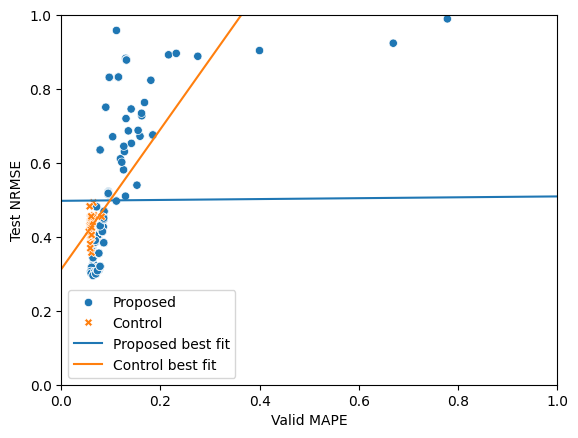

In [ ]:
valid_metric = (
    MODEL_SELECTION_CRITERION
    if MODEL_SELECTION_CRITERION.startswith("Valid")
    else "Valid " + MODEL_SELECTION_CRITERION.split(" ")[1]
)
test_metric = (
    "Test " + MODEL_EVALUATION_CRITERION.split(" ")[1]
    if MODEL_EVALUATION_CRITERION.startswith("Valid")
    else MODEL_EVALUATION_CRITERION
)
sns.scatterplot(
    data=results_df, x=valid_metric, y=test_metric, hue="Type", style="Type"
)
plt.xlim(*AXIS_LIM)
plt.ylim(*AXIS_LIM)
# Calculate correlations for each category
correlations = results_df.groupby("Type")[results_df.columns].apply(
    lambda df: df[valid_metric].corr(df[test_metric])
)
print("Correlations between Valid and Test metrics:")
print("Control", correlations.get("Control", np.nan))
print("Proposed", correlations.get("Proposed", np.nan))

# Add best fit lines for each category
for typ in results_df["Type"].unique():
    subset = results_df[results_df["Type"] == typ]
    x = subset[valid_metric]
    y = subset[test_metric]
    m, b = np.polyfit(x, y, 1)
    x_line = np.linspace(*AXIS_LIM, 100)
    plt.plot(x_line, m * x_line + b, label=f"{typ} best fit")
plt.legend()
plt.show()

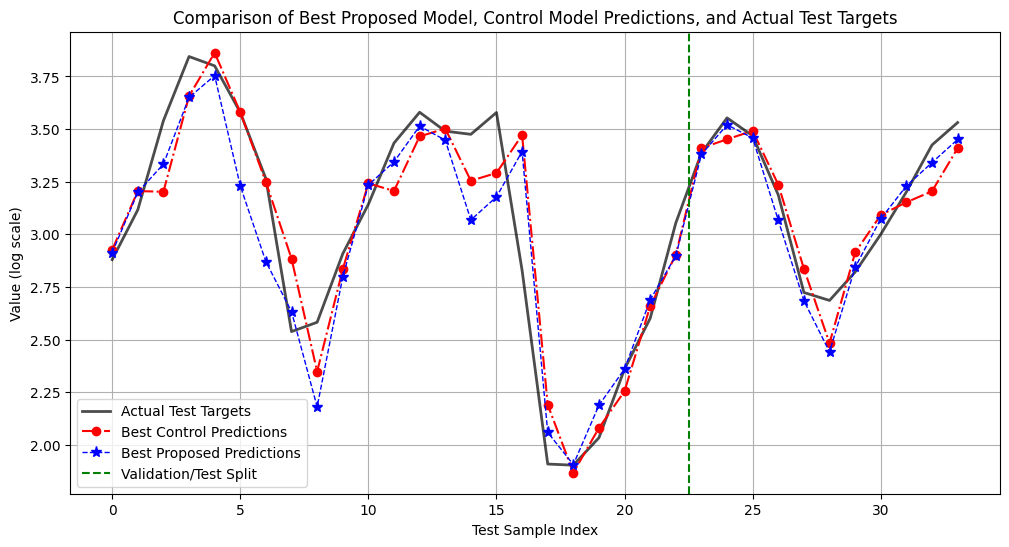

In [708]:
# Find the index of the best proposed model based on lowest Test NRMSE
best_proposed_idx = results_df[results_df["Type"] == "Proposed"][
    MODEL_SELECTION_CRITERION
].idxmax() if MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE else results_df[results_df["Type"] == "Proposed"][
    MODEL_SELECTION_CRITERION
].idxmin()
best_proposed_res = proposed_results[best_proposed_idx]

best_control_idx = results_df[results_df["Type"] == "Control"][
    MODEL_SELECTION_CRITERION
].idxmax() if MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE else results_df[results_df["Type"] == "Control"][
    MODEL_SELECTION_CRITERION
].idxmin()
best_control_res = control_results[best_control_idx - len(proposed_results)]

# Get test targets (actual values for test set)
test_targets = best_proposed_res.test_targets  # Assuming all have the same test_targets

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_targets, label="Actual Test Targets", color="black", linewidth=2,  alpha=.7)
plt.plot(
    best_control_res.test_predictions,
    label=f"Best Control Predictions",
    color="red",
    linestyle="-.",
    marker='o',
)
plt.plot(
    best_proposed_res.test_predictions,
    label=f'Best Proposed Predictions',
    color="blue",
    linestyle="--",
    linewidth=1,
    marker='*',
    markersize=8,
)
plt.axvline(x=validation_cutoff + 0.5, color='green', linestyle='--', label='Validation/Test Split')
plt.xlabel("Test Sample Index")
plt.ylabel("Value (log scale)")
plt.title(
    "Comparison of Best Proposed Model, Control Model Predictions, and Actual Test Targets"
)
plt.legend()
plt.grid(True)
plt.show()

### Effects of individual hyperparameters

In [735]:
# HYPERPARAM = "optimizer._epsilon"
HYPERPARAM = "num_components"
METRIC_LOG_SCALE = True
PARAM_LOG_SCALE = True

PROPOSED_HYPERPARAM = False

In [736]:
hyperparam_values = sorted(
    map(
        lambda cfg: cfg.__dict__.get(HYPERPARAM, None),
        proposed_configs if PROPOSED_HYPERPARAM else control_configs,
    )
    if not HYPERPARAM.startswith("optimizer.")
    else
    map(
        lambda cfg: cfg.optimizer.__dict__.get(HYPERPARAM.split(".")[1], None),
        proposed_configs if PROPOSED_HYPERPARAM else control_configs,
    )
)
hyperparam_results_df = results_df[results_df["Type"] == ("Proposed" if PROPOSED_HYPERPARAM else "Control")].copy()
hyperparam_results_df[HYPERPARAM] = hyperparam_values

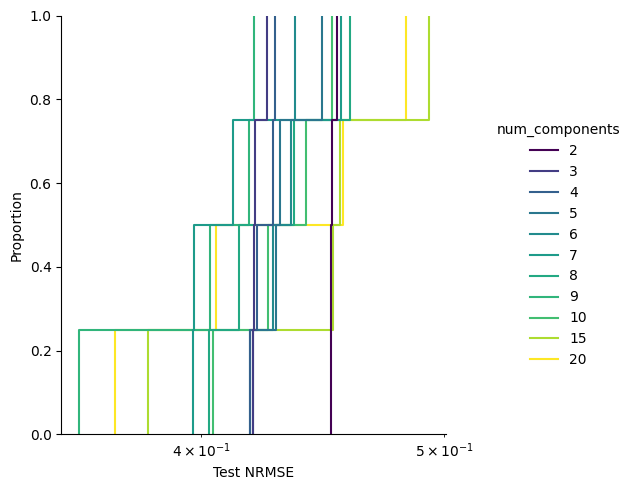

In [737]:
sns.displot(
    data=hyperparam_results_df,
    x=test_metric,
    hue=HYPERPARAM,
    hue_norm=LogNorm() if PARAM_LOG_SCALE else None,
    kind="ecdf",
    palette="viridis",
    log_scale=(METRIC_LOG_SCALE, False),
)
# plt.xlim(right= np.log10(hyperparam_results_df[test_metric].max() / 10))
plt.show()

### Control models

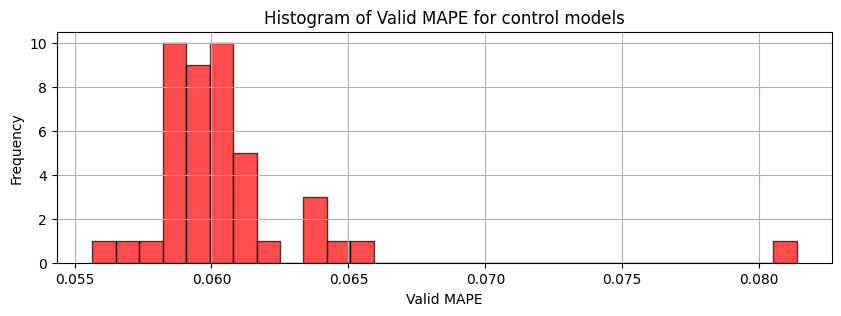

In [724]:
control_models = results_df[results_df["Type"] == "Control"]
plt.figure(figsize=(10, 3))
plt.hist(control_models[MODEL_SELECTION_CRITERION], bins=30, alpha=0.7, color='red', edgecolor='black')
plt.title(f'Histogram of {MODEL_SELECTION_CRITERION} for control models')
plt.xlabel(MODEL_SELECTION_CRITERION)
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Breakdown of methods

#### Best OLS model without tuning

In [ ]:
# Filter for models with "OLS" in their name (case-insensitive) and "tuned=False"
not_tuned_ols_models = results_df[
    results_df["Name"].str.contains("OLS", case=False, na=False)
    & results_df["Name"].str.contains("tuned=False", case=False, na=False)
]

if not_tuned_ols_models.empty:
    best_not_tuned_ols_model = None
else:
    # Select the best based on minimizing Test NRMSE
    best_not_tuned_ols_model = not_tuned_ols_models.loc[
        (
            not_tuned_ols_models[MODEL_SELECTION_CRITERION].idxmin()
            if not MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE
            else not_tuned_ols_models[MODEL_SELECTION_CRITERION].idxmax()
        )
    ]

if best_not_tuned_ols_model is None:
    print("No untuned OLS models found.")
else:
    print(best_not_tuned_ols_model["Name"])
    print("=" * 20)
    print(best_not_tuned_ols_model.drop(labels=["Type", "Name"]))

No untuned OLS models found.


In [ ]:
if not not_tuned_ols_models.empty:
    plt.figure(figsize=(10, 3))
    plt.hist(not_tuned_ols_models[MODEL_SELECTION_CRITERION], bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'Histogram of {MODEL_SELECTION_CRITERION} for not tuned OLS Models')
    plt.xlabel(MODEL_SELECTION_CRITERION)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
else:
    print("No untuned OLS models found, skipping histogram.")

No untuned OLS models found, skipping histogram.


#### Best OLS-based model with tuning

In [ ]:
# Filter for models with "OLS" in their name (case-insensitive) and "tuned=False"
tuned_ols_models = results_df[results_df["Name"].str.contains("OLS", case=False, na=False) & 
                        results_df["Name"].str.contains("tuned=True", case=False, na=False)]

if tuned_ols_models.empty:
    best_tuned_ols_model = None
else:
    # Select the best based on minimizing Test NRMSE
    best_tuned_ols_model = tuned_ols_models.loc[
        (
            tuned_ols_models[MODEL_SELECTION_CRITERION].idxmin()
            if not MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE
            else tuned_ols_models[MODEL_SELECTION_CRITERION].idxmax()
        )
    ]

if best_tuned_ols_model is None:
    print("No tuned OLS models found.")
else:
    print(best_tuned_ols_model["Name"])
    print("="*20)
    print(best_tuned_ols_model.drop(labels=["Type", "Name"]))

No tuned OLS models found.


In [ ]:
if tuned_ols_models.empty:
    print("No tuned OLS models found, skipping histogram.")
else:
    plt.figure(figsize=(10, 3))
    plt.hist(tuned_ols_models[MODEL_SELECTION_CRITERION], bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'Histogram of {MODEL_SELECTION_CRITERION} for tuned OLS models')
    plt.xlabel(MODEL_SELECTION_CRITERION)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

No tuned OLS models found, skipping histogram.


#### Best SVD-based model without tuning

In [ ]:
# Filter for models with "SVD" in their name (case-insensitive) and "tuned=True"
not_tuned_svd_models = results_df[results_df["Name"].str.contains("SVD", case=False, na=False)]
not_tuned_svd_models = not_tuned_svd_models[not_tuned_svd_models["Name"].str.contains("tuned=False", case=False, na=False)]

if not_tuned_svd_models.empty:
    best_not_tuned_svd_model = None
else:
    # Select the best based on minimizing Test NRMSE
    best_not_tuned_svd_model = not_tuned_svd_models.loc[
        (
            not_tuned_svd_models[MODEL_SELECTION_CRITERION].idxmin()
            if not MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE
            else not_tuned_svd_models[MODEL_SELECTION_CRITERION].idxmax()
        )
    ]

print(best_not_tuned_svd_model["Name"])
print("="*20)
print(best_not_tuned_svd_model.drop(labels=["Type", "Name"]))

SvdOptimizer-w.no-pretraining(m=100, alpha=0.1, eps=0.0001 tuned=False)
Test R        0.978242
Test R^2      0.949323
Test MSE      0.006949
Test RMSE     0.083358
Test NRMSE    0.225657
Test MAPE     0.020401
Test SMAPE    0.010352
Test MAAPE    0.020387
Name: 1153, dtype: object


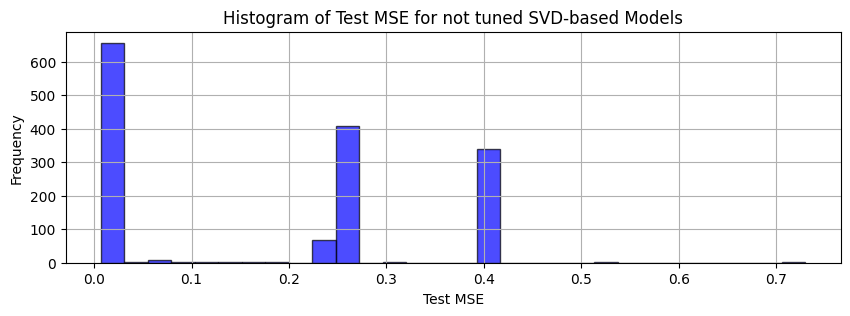

In [ ]:
plt.figure(figsize=(10, 3))
plt.hist(not_tuned_svd_models[MODEL_SELECTION_CRITERION], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title(f'Histogram of {MODEL_SELECTION_CRITERION} for not tuned SVD-based Models')
plt.xlabel(MODEL_SELECTION_CRITERION)
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### Best SVD-based model with tuning

In [ ]:
# Filter for models with "SVD" in their name (case-insensitive) and "tuned=True"
tuned_svd_models = results_df[results_df["Name"].str.contains("SVD", case=False, na=False)]
tuned_svd_models = tuned_svd_models[
    tuned_svd_models["Name"].str.contains("tuned=True", case=False, na=False)
]

if tuned_svd_models.empty:
    best_tuned_svd_model = None
else:
    # Select the best based on minimizing Test NRMSE
    best_tuned_svd_model = tuned_svd_models.loc[
        (
            tuned_svd_models[MODEL_SELECTION_CRITERION].idxmin()
            if not MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE
            else tuned_svd_models[MODEL_SELECTION_CRITERION].idxmax()
        )
    ]

print(best_tuned_svd_model["Name"])
print("=" * 20)
print(best_tuned_svd_model.drop(labels=["Type", "Name"]))

SvdOptimizer-w.pretraining(m=100, alpha=0.01, eps=0 tuned=True)
Test R        0.978072
Test R^2      0.950985
Test MSE      0.006721
Test RMSE      0.08198
Test NRMSE    0.216678
Test MAPE     0.023502
Test SMAPE    0.011733
Test MAAPE    0.023491
Name: 886, dtype: object


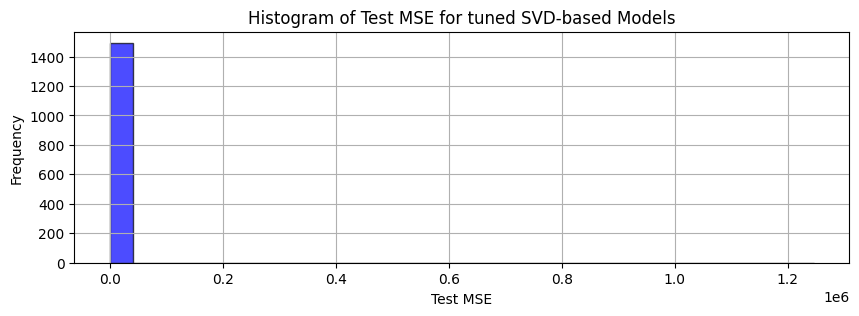

In [ ]:
plt.figure(figsize=(10, 3))
plt.hist(tuned_svd_models[MODEL_SELECTION_CRITERION], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title(f'Histogram of {MODEL_SELECTION_CRITERION} for tuned SVD-based Models')
plt.xlabel(MODEL_SELECTION_CRITERION)
plt.ylabel('Frequency')
plt.grid(True)
plt.show()